# Simulating Future Flood Maps
In order to evaluate coastal vulnurability caused by Sea level rise during 21th century, future flood maps for the study area are produced. For future flood simulaton we assume that the coastal lands whose elevations are lower than future sea level height will be flooded. Therefore, we need to compare the **Digital Elevation Model** and **future sea level height**. To produce future sea level height,  **sea level change projections** dataset is used as the main dataset. This dataset is associated with Working Group 1 (WG1) of the Sixth Assessment Report (AR6) of Intergovernmental Panel on Climate Change (**IPCC**). https://www.ipcc.ch/report/ar6/wg1/ These projections are performed with respect to the baseline of 1995 to 2014 and for each 10-year future epochs from 2020 to 2150. Therefore, for computing future sea level height, we need to add this sea level change to the mean sea surface over the period 1995 to 2014. 
To create the Digital Elevation Model the Geoid is added to the Bedrock elevation. 
Finally comparing the DEM and future sea level height in QGIS, the map of flooded and non-flooded area is produced.

Here, as a case study, the process is performed for Vietnam bounding box.


# IPCC Sea Level Change Projection dataset

The IPCC Working Group I contribution (the Physical Science Basis team) was released on 9 August 2021. Chapter 9 of the report assesses past and projected changes in the ocean, cryosphere and sea level using paleoreconstructions, instrumental observations and model simulations. https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-9/ 
In section 9.6 the sea level change is discussed in Global and Regional scale and in pre-satelite and satelite ara. Since this research aims to take the regional variability into account, the relative sea level projections dataset is employed as sea level change of future epochs (under ar6-regional-confidence.zip) https://zenodo.org/record/5914710 . The dataset is based on updated simulations obtained from the Coupled Model Intercomparison Project Phase 6 (CMIP6) ensemble. These simulations enable the projection of ocean dynamic sea level contributions to regional sea level change. Data of regional analysis are available in low confidence an medium confidence which refer to the level of uncertainity in the projections. Here we focud on medium confidence. Regional sea level can differ from the global mean sea level change due to various factors such as vertical land movement, ice mass changes, and ocean dynamical changes. For each of 5 climate change scenarios, different levels of sea level change are projected. Here, we consider the two scenarios SSP1-1.9 and SSP5-8.5 that correspond to the minimum and maximum emission trajectories.
The impacts of all contributors of sea level change are studied individually and totally in different datasets. These contributors include: thermal expansion, Greenland and Antarctic ice sheet contributions, glacier melt, vertical land motion and land-water storage. Since no single model can directly compute all these contributions, they are calculated individually and subsequently combined. Thus, the dataset used for this research encompasses the total combination of all drivers. 


In [4]:
#necessary packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.interpolate import griddata
import rasterio
from rasterio.plot import show
import cartopy.crs as ccrs
from rasterio.transform import from_origin
import fiona
import rasterio.mask
import geopandas as gpd
from osgeo import gdal
from rasterio.mask import mask
import cartopy.feature as cfeature
import matplotlib.colors as colors
from shapely.geometry import Polygon
import matplotlib.cm as cm #colormap module
import cmocean #colormap for oceanography https://matplotlib.org/cmocean/
import warnings
warnings.filterwarnings('ignore')

In [5]:
#%matplotlib widget

## Dataset overview
The IPCC sea level change projection dataset for regional medium confidence is a collection of netcdf files. For each scenario there are 6x2 files (sea level change value and rate for each contributor) and 1x2 (value and rate)for the total combination of the contributors. Here we consider the values of the total combination dataset for two scanarios: SSP119 , SSP585.

In [6]:
#directory of the data for the two scenarios: SSP119 and SSP585
ssp119_dir = '/home/sahar/Data/IPCC/ar6-regional-confidence/regional/confidence_output_files/medium_confidence/ssp119/total_ssp119_medium_confidence_values.nc'
ssp585_dir = '/home/sahar/Data/IPCC/ar6-regional-confidence/regional/confidence_output_files/medium_confidence/ssp585/total_ssp585_medium_confidence_values.nc'
#open netcdf files
SLC_IPCC_ssp119 = xr.open_dataset(ssp119_dir)
SLC_IPCC_ssp585 = xr.open_dataset(ssp585_dir)

Dataset for SSP119:

In [7]:
SLC_IPCC_ssp119

<xarray.Dataset>
Dimensions:           (locations: 66190, quantiles: 107, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
  * quantiles         (quantiles) float64 0.0 0.001 0.005 ... 0.995 0.999 1.0
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (quantiles, years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:47:32 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...

The dataset has geographical coordinate system with 10-year temporal resolution and temporal coverage from 2020 to 2150. It contains **1030 Tide Guage** (non-grid) data points and **65190 altimetry grid points**. Geographical resolution of altimetry dataset is **1 Degree** East longitude  1 Degree North latitude and the geograhical coverage is the whole earth (-180, -90, 180, 90).
The coordinates and dimensions of the dataset are years, locations and quantiles.

The **years**, include 14 time epochs from 2020 to 2150.

The **locations** coordinate, is a unique id for each lat-lon point of data (66190 locations that contain 65160 altimetry and 1030 tide guage data points).

The **quantile** refers to the probability and is a value between 0 to 1.

The variables of the dataset are latitude, longitude and sea level change. 


## Data Preprocessing

To narrow down the complexity of uncertainity of the dataset we focus on quntile=0.5 as median.
For this test two years of 2020 and 2100 are considered.
Also just altimetry data is intended so the tide guage data (with non-grid latitude or longitude will be dropped from the process).
In order to make the dataset compatable for the GIS environment we need to have the latitude and longitude in the dimensions. To do so, the data are interpolated with nearest method. The result are Geotiff maps that are readable in GIS software. 

### Extracting 50% quantiles

In [8]:
#select the median (50% probability)
SLC_median_ssp119 = SLC_IPCC_ssp119.sel(quantiles=0.50, method='nearest')
SLC_median_ssp119 = SLC_median_ssp119.drop_vars('quantiles') #drop quantiles from the the data
SLC_median_ssp585 = SLC_IPCC_ssp585.sel(quantiles=0.50, method='nearest')
SLC_median_ssp585 = SLC_median_ssp585.drop_vars('quantiles')
print(f'dataset for the scenario ssp119 {SLC_median_ssp119}') #drop quantiles from the the data
print('***************************************')
print(f'dataset for the scenario ssp585 {SLC_median_ssp585}')

dataset for the scenario ssp119 <xarray.Dataset>
Dimensions:           (locations: 66190, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:47:32 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...
***************************************
dataset for the scenario ssp585 <xarray.Dataset>
Dimensions:           (locations: 66190, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
Data variables:
    lat               (loc

### Selecting altimetry data
Only grid data with integer latitude and longitude will be considered.

In [9]:
#extract grid (altimetry data)
SLC_median_ssp119 = SLC_median_ssp119.sel(locations=(SLC_median_ssp119.lat % 1 == 0) & (SLC_median_ssp119.lon % 1 == 0))
SLC_median_ssp585 = SLC_median_ssp585.sel(locations=(SLC_median_ssp585.lat % 1 == 0) & (SLC_median_ssp585.lon % 1 == 0))

In [10]:
#median sea level change for the scenario SSP585
SLC_median_ssp585 

<xarray.Dataset>
Dimensions:           (locations: 65160, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1000000000 1000000010 ... 1018003590
Data variables:
    lat               (locations) float32 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
    lon               (locations) float32 0.0 1.0 2.0 3.0 ... -3.0 -2.0 -1.0
    sea_level_change  (years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:53:19 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...

### Interpolation of IPCC altimetry data Sea Level Change
The Interpolation for the years 2020 and 2100 of the scenario SSP119 and SSP585 is carried out for altimetry data with 0.5 degree resolution. The process has been performed with **Scipy-interpolation** library and the results- which are 4 maps- are saved as **Geotiff** with **rasterio** package with the coordinate refernce of original data which is 4326 (**WGS48**) and plotted with **Cartopy** package.

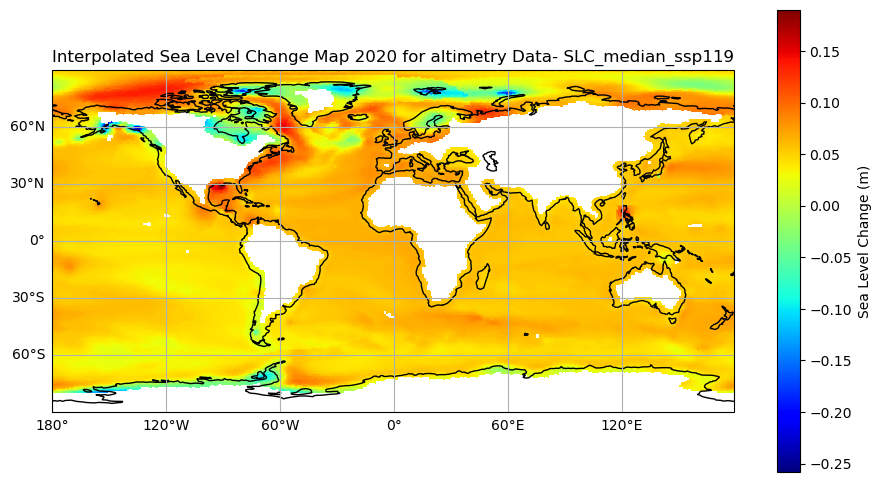

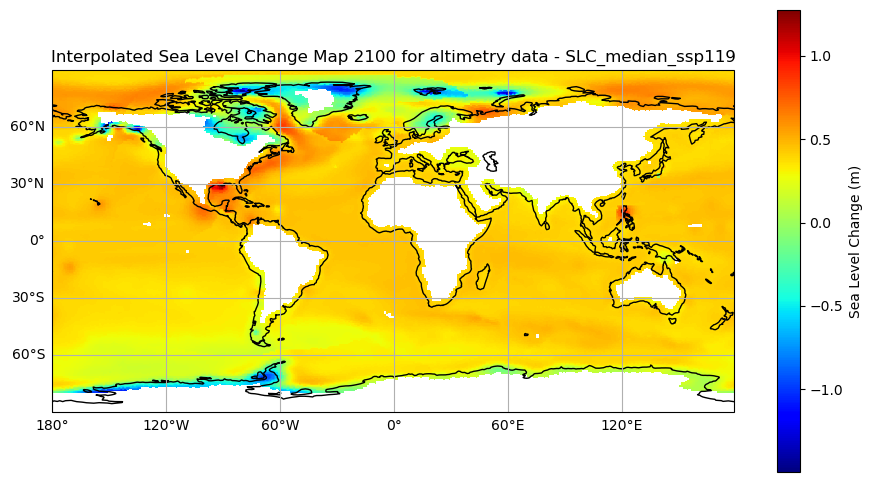

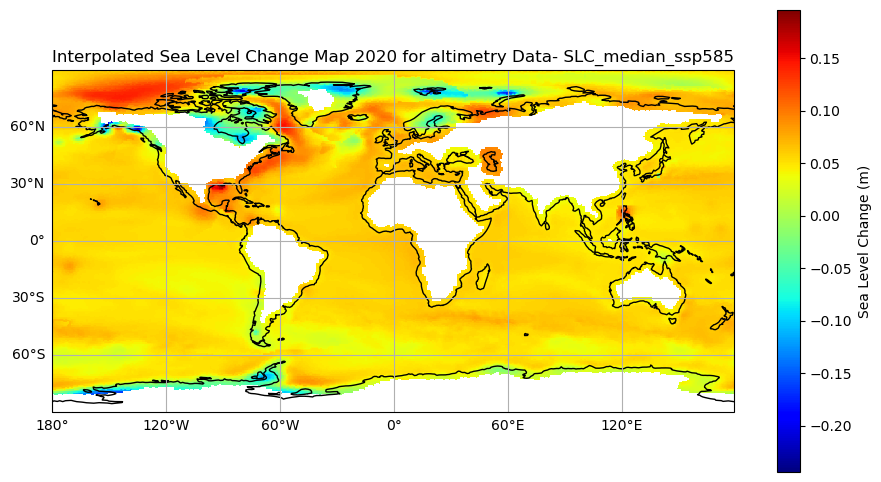

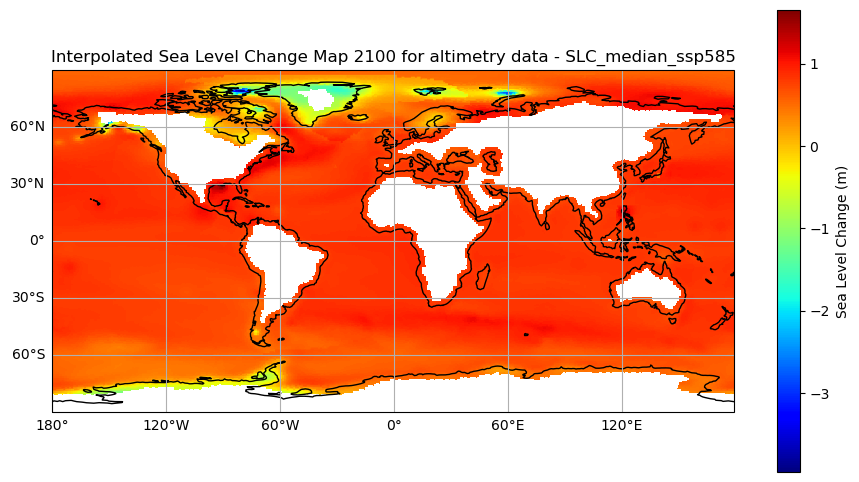

In [11]:
#creating list of SLC datasets
SLC_scn_list = ['SLC_median_ssp119', 'SLC_median_ssp585']
# Specify the directory for saving the geotif results
SLC_outputDir = '/home/sahar/output_tif/grid2'

#define integrated legend for all maps
#n= 30 #range of colors
#cmap = cm.get_cmap('jet', n-1) #create cmap of n-1 ranges
#cranges = np.linspace(-2, 2, n) #(put n ranges btw min SLC and max SLC)
#norms = colors.BoundaryNorm(cranges, cmap.N)

#loop over the datasets to do the interpolation for the year 2020 and 2100 for ssp119 and ssp585
for SLC_scn in SLC_scn_list:
    #getting the data set
    dataset = globals()[SLC_scn]
    
    #extract sea level change for 2020
    sea_level_2020 = dataset['sea_level_change'].sel(years=2020)
    
    #extract sea level change for 2100
    sea_level_2100 = dataset['sea_level_change'].sel(years=2100)
    
    #inputs of the interpolation for 2020
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    sea_level_values_2020 = sea_level_2020.values.flatten() / 1000  # Convert mm to m
    
    #inputs of the interpolation for 2100
    sea_level_values_2100 = sea_level_2100.values.flatten() / 1000  # Convert mm to m

    #create a lat-lon grid with 0.5-degree resolution
    lat_grid = np.arange(np.max(lat), np.min(lat) - 0.5, -0.5)
    lon_grid = np.arange(np.min(lon), np.max(lon) + 0.5, 0.5)
    #generate grid
    xi_lon_grid, xi_lat_grid = np.meshgrid(lon_grid, np.flip(lat_grid))
    xi_points = np.column_stack((xi_lat_grid.ravel(), xi_lon_grid.ravel()))  # To put grid-lat, grid_lon_1d in one 2d array
    points = np.column_stack((lat, lon))  # To put original lat lon in one 2d array

    
    #pertrform interpolation of SLC on xi_points based on nearest neighbor method for 2020
    interpolated_sea_level_change_nearest_2020 = griddata(points, sea_level_values_2020, xi_points, method='nearest')

    #pertrform interpolation of SLC on xi_points based on nearest neighbor method for 2100
    interpolated_sea_level_change_nearest_2100 = griddata(points, sea_level_values_2100, xi_points, method='nearest')

    #reshape the interpolated arrays to match the grid shape
    interpolated_sea_level_change_nearest_2020 = np.reshape(interpolated_sea_level_change_nearest_2020, xi_lon_grid.shape)
    interpolated_sea_level_change_nearest_2100 = np.reshape(interpolated_sea_level_change_nearest_2100, xi_lon_grid.shape)
    
    tif_2020 = f'sea_level_change_map_nearest2020_{SLC_scn}.tif'
    height, width = interpolated_sea_level_change_nearest_2020.shape #get the dimensions of the interpolated sea level change array
    # define the affine transformation matrix for the geotiff
    # the origin is set to the minimum longitude and maximum latitude
    #thepixel size is set to the resolution of the latitude and longitude arrays
    transform = from_origin(np.min(lon_grid), np.min(lat_grid), lon_grid[1] - lon_grid[0], lat_grid[1] - lat_grid[0])
    
    #save the figure as a GeoTIFF for 2020
    tif_2020 = os.path.join(SLC_outputDir, f'sea_level_change_alt_2020_{SLC_scn}.tif')
    with rasterio.open(tif_2020, 'w', driver='GTiff', height=height, width=width, count=1, dtype=interpolated_sea_level_change_nearest_2020.dtype, crs='EPSG:4326', transform=transform) as dst:
        dst.write(interpolated_sea_level_change_nearest_2020, 1)
    #print(f"{tif_2020} is saved.")


    tif_2100 = f'sea_level_change_map_nearest2100_{SLC_scn}.tif'
    height, width = interpolated_sea_level_change_nearest_2100.shape #get the dimensions of the interpolated sea level change array
    # define the affine transformation matrix for the geotiff
    # the origin is set to the minimum longitude and maximum latitude
    #thepixel size is set to the resolution of the latitude and longitude arrays
    transform = from_origin(np.min(lon_grid), np.min(lat_grid), lon_grid[1] - lon_grid[0], lat_grid[1] - lat_grid[0])
    # Save the figure as a GeoTIFF for 2100
    tif_2100 = os.path.join(SLC_outputDir, f'sea_level_change_alt_2100_{SLC_scn}.tif')
    with rasterio.open(tif_2100, 'w', driver='GTiff', height=height, width=width, count=1, dtype=interpolated_sea_level_change_nearest_2100.dtype, crs='EPSG:4326', transform=transform) as dst:
        dst.write(interpolated_sea_level_change_nearest_2100, 1)
    #print(f"{tif_2100} is saved.")

     #flip the interpolated arrays vertically
    interpolated_sea_level_change_nearest_2020 = np.flipud(interpolated_sea_level_change_nearest_2020)
    interpolated_sea_level_change_nearest_2100 = np.flipud(interpolated_sea_level_change_nearest_2100)
    
    #plot the interpolation for 2020
    plt.figure(figsize=(11, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    #im = ax.imshow(interpolated_sea_level_change_nearest_2020, extent=[np.min(lon_grid), np.max(lon_grid), np.min(lat_grid), np.max(lat_grid)], cmap=cmap, norm=norms) #integrated legend
    im = ax.imshow(interpolated_sea_level_change_nearest_2020, extent=[np.min(lon_grid), np.max(lon_grid), np.min(lat_grid), np.max(lat_grid)], cmap='jet')

    plt.colorbar(im, label='Sea Level Change (m)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Interpolated Sea Level Change Map 2020 for altimetry Data- {SLC_scn}')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    
    #plot the interpolation for 2100
    plt.figure(figsize=(11, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    #im = ax.imshow(interpolated_sea_level_change_nearest_2100, extent=[np.min(lon_grid), np.max(lon_grid), np.min(lat_grid), np.max(lat_grid)], cmap=cmap, norm=norms) #integrated legend
    im = ax.imshow(interpolated_sea_level_change_nearest_2100, extent=[np.min(lon_grid), np.max(lon_grid), np.min(lat_grid), np.max(lat_grid)], cmap='jet')

    plt.colorbar(im, label='Sea Level Change (m)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Interpolated Sea Level Change Map 2100 for altimetry data - {SLC_scn}')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False


## Sea Level Change in Vietnam Bounding Box
In order to produce future flood maps for the study area- here Vietnam- first bounding box of Vietnam is created, Then the future sea level change for the bounding box is masked from the global interpolated maps of IPCC sea level change.

### Creating Vietnam bounding Box
The bounding box of Vietnam is created as a shapefile using **geopandas** and **Shapely** packages.

In [12]:
#bounding box coordinates
bbox = (102, 8, 110, 24) #https://gist.github.com/graydon/11198540
#creating polygon using shapely
polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
#making a geodataframe with the polygon
gdf = gpd.GeoDataFrame(geometry=[polygon])
#set the coordinate to wgs84
gdf.crs = "EPSG:4326"
#output shapefile path
area_bbox = "/home/sahar/output_shp/Vietnam_bbox.shp"
#save as shapefile
gdf.to_file(area_bbox)
area_bbox= gpd.read_file(area_bbox)


### Masking the Future Sea Level Change for the study area
Using **rasterio** library, the 4 the sea level global change maps have been masked with Vietnam bounding box shapefile. Then the results are saved as Geotiff files with rasterio package and plotted with Cartopy package.

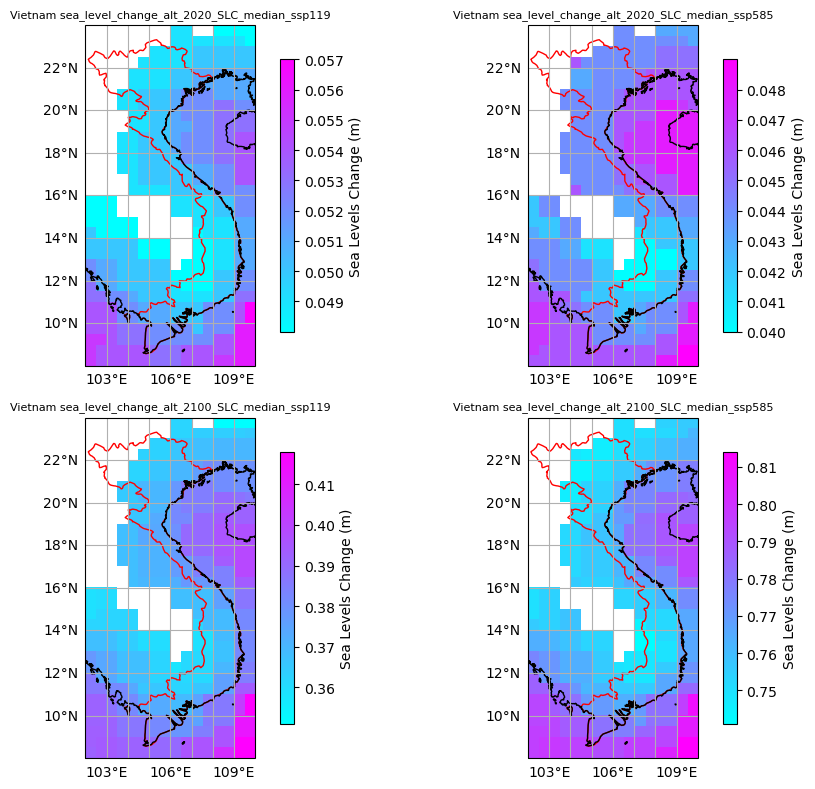

In [13]:
# path to the area bbox
area_bbox = "/home/sahar/output_shp/Vietnam_bbox.shp"

# define the output directory for saving the masked tif
area_SLC_dir = "/home/sahar/output_tif/grid2"

# the shapefile of the administrative boundries of the area is downloaded from : https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/?q=Vietnam
area_adm_path = "/home/sahar/Data/Vietnam/Vietnam-boundaries.shp" 
shapefile = gpd.read_file(area_adm_path)

#create geodataframe out of the shapefile of boundries
gdf = gpd.GeoDataFrame(geometry=shapefile["geometry"])

#list of global interpolated sea level change of IPCC
IPCC_SLC = [
    "/home/sahar/output_tif/grid2/sea_level_change_alt_2020_SLC_median_ssp119.tif",
    "/home/sahar/output_tif/grid2/sea_level_change_alt_2020_SLC_median_ssp585.tif",
    "/home/sahar/output_tif/grid2/sea_level_change_alt_2100_SLC_median_ssp119.tif",
    "/home/sahar/output_tif/grid2/sea_level_change_alt_2100_SLC_median_ssp585.tif"
]

#read the shapefile and extract the shapes
with fiona.open(area_bbox, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

#set the figure size
fig = plt.figure(figsize=(10, 8))


#define the same legend for all maps in order to be comparable
#n= 10 #range of colors
#cmap = cm.get_cmap('cool', n-1) #create cmap of n-1 ranges
#cranges = np.linspace(0.04, 0.81, n) #(put n ranges btw min SLC and max SLC) needs to update with change in the map
#norm = colors.BoundaryNorm(cranges, cmap.N)

#mask and plot for all subsets in a loop
for i, SLC in enumerate(IPCC_SLC):
    #extract the filename without the directory path& extension
    filename = os.path.splitext(os.path.basename(SLC))[0]

    # define the output path for the masked tif
    areaSLC_dir = os.path.join(area_SLC_dir, f"Vietnam_{filename}.tif")

    #open the sea level change 
    with rasterio.open(SLC) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=src.nodata)
        out_meta = src.meta

        #replace the out of mask pixels with nodata value
        out_image = np.where(out_image == 0, src.nodata, out_image)

        #set the NoData value in the metadata
        out_meta["nodata"] = src.nodata

    #update the metadata for the masked tiff
    out_meta.update(
        driver="GTiff",
        height=out_image.shape[1],
        width=out_image.shape[2],
        transform=out_transform
    )

    # write the masked Ttif to the output path
    with rasterio.open(areaSLC_dir, "w", **out_meta) as dest:
        dest.write(out_image)

    #open the masked TIFF file
    with rasterio.open(areaSLC_dir) as src:
        # Read the image data
        image = src.read(1)
        # Get the transform and bounds of the image
        transform = src.transform
        bounds = src.bounds
        
         #flip vertically
    image = np.flipud(image)

    #create a cartopy geoaxis instance
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree())
    
    # add the image to the plot
    #img = ax.imshow(image, extent=(bounds.left, bounds.right, bounds.top, bounds.bottom), origin='upper', cmap=cmap, norm= norm)
    img = ax.imshow(image, extent=(bounds.left, bounds.right, bounds.top, bounds.bottom), origin='upper', cmap='cool')

    #Add the area-adm to the plot
    ax.add_geometries(gdf["geometry"], crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")

    ax.coastlines()

    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label('Sea Levels Change (m)')
    ax.set_title(f"Vietnam {filename}", fontsize = 8)

plt.tight_layout()
plt.show()


The red border is the administrative boundries of Vietnam. The black line is the coastal line.

# Geoid and Digital Elevation Model
The geoid is a model of global mean sea level that is used to measure precise surface elevations. The radius at the equator is larger than at the poles due to the long-term effects of the earth's rotation. And, at a smaller scale, there is topography—mountains have more mass than a valley and thus the pull of gravity is regionally stronger near mountains. All of these large and small variations to the size, shape, and mass distribution of the earth cause slight variations in the acceleration of gravity (or the "strength" of gravity's pull). These variations determine the shape of the planet's liquid environment.
If one were to remove the tides and currents from the ocean, it would settle onto a smoothly undulating shape (rising where gravity is high, sinking where gravity is low). This irregular shape is called **"the geoid,"** a surface which defines **zero elevation**. This model is used to measure surface elevations with a high degree of accuracy. https://oceanservice.noaa.gov/facts/geoid.html, 7/8/2023

The **ETOPO** elevations are used to compute DEM. ETOPO 2022 is a release of **NOAA’s “Earth TOPOgraphy”** dataset. It is a full-coverage, seamless,gridded topographic and bathymetric bare-earth elevation dataset.https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/docs/1.2%20ETOPO%202022%20User%20Guide.pdf, 7/8/2023
The **ETOPO**Global Relief Model- from **National Center for Environmental Information (NCEI)** integrates topography, bathymetry, and shoreline data from regional and global datasets to enable comprehensive, high resolution renderings of geophysical characteristics of the earth’s surface. The model is designed to support tsunami forecasting, modeling, and warning, as well as ocean circulation modeling and Earth visualization. The current version, ETOPO 2022, is available in **Ice Surface** and **Bedrock** versions that portray either the top layer of the ice sheets covering Greenland and Antarctica, or the bedrock below. https://www.ncei.noaa.gov/products/etopo-global-relief-model, 7/8/2023

To obtain the Geoid of Vietnam, two high resolution grid tiles in 15 arc seconds resolution (ETOPO_2022_v1_15s_N30E075_geoid, and ETOPO_2022_v1_15s_N30E090_geoid) are downloded from ETOPO 2020 Geoid height geotiff.  https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/data/15s/15s_geoid_gtif/ , 7/1/2023


The tiles, then have been merged in QGIS software using Raster> Miscellaneous> Merge function and clipped by Vietnam bbox (Raster> Extraction> clip Raster by Mask layer) for the intended bbox.


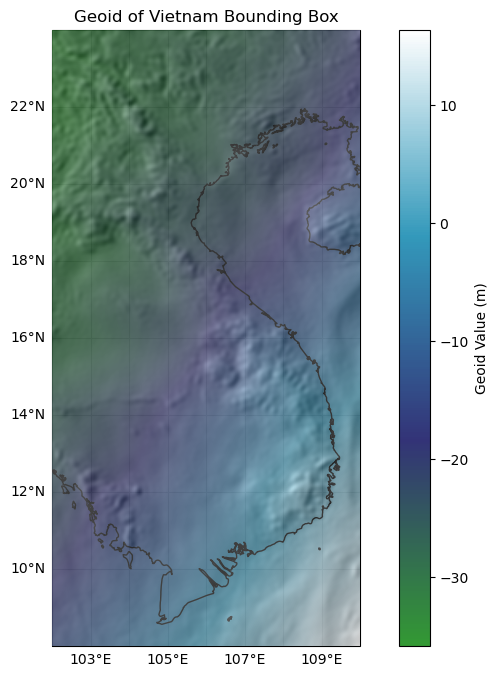

In [14]:

#geoid directory
geoid_path = '/home/sahar/output_tif/Vietnam_bbox_Geoid_15s.tif'

#read geoid
with rasterio.open(geoid_path) as src:
    # Read the geoid data as a numpy array
    geoid_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(geoid_array, 330, 30)

#get the extent of the geoid
with rasterio.open(geoid_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.coastlines(zorder= 10)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot geoid
cax = ax.imshow(geoid_array, cmap='ocean', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Geoid Value (m)')
plt.title('Geoid of Vietnam Bounding Box')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Digital Elevation Model and Bedrock Elevation


 All ETOPO tiles are in horizontal WGS84 geographic coordinates (EPSG:4326) and referenced in meters relative to the Earth Gravitational Model of 2008 (EGM2008) geoid surface (EPSG:3855). Each tile comes with an accompanying “geoid” tile for converting EGM2008 geoid heights into WGS84 ellipsoid elevation heights (EPSG:4979). 

**Elevation Conversion**

To convert a given tile from EGM2008 to WGS84-referenced elevations, we need to add the values of the elevation tile to the geoid-height tile:

   **ETOPO Elevation (EGM2008) + GEOID = WGS84 Elevation**

https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/docs/1.2%20ETOPO%202022%20User%20Guide.pdf, 7/8/2023

Therefore, to compute the elevation model, the bedrock elevation needs to be added to the Geoid. Bedrock elevation of the study area is obtained from the ETOPO 2022 Bedrock model with 15 arcsecond resolution and is Extracted from the Grid Extractor function for Vietnam bbox as Geotiff files. https://www.ncei.noaa.gov/maps/grid-extract/ 7/1/2023


## Bedrock Elevation

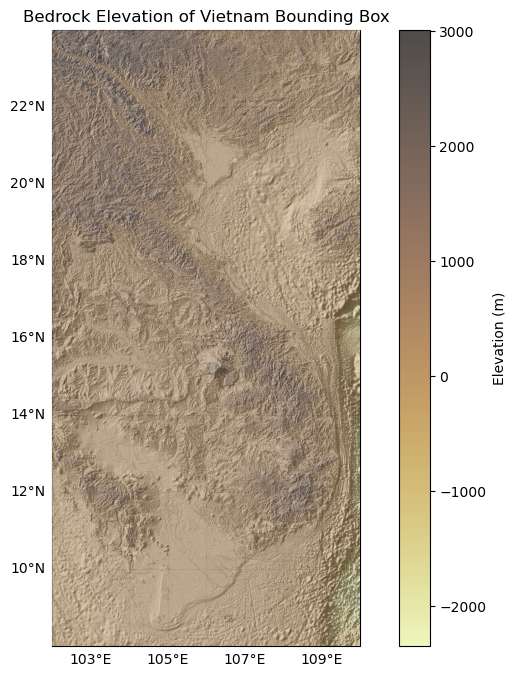

In [15]:
#bedrock directory
bedrock_path = '/home/sahar/output_tif/Vietnam_Bedrock_15arcsec.tiff'

#read bedrock
with rasterio.open(bedrock_path) as src:
    # Read the bedrock data as a numpy array
    bedrock_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(bedrock_array, 330, 30)

#get the extent of the bedrock
with rasterio.open(bedrock_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
#ax.coastlines(zorder= 15)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot bedrock
cax = ax.imshow(bedrock_array, cmap=cmocean.cm.turbid, extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Elevation (m)')
plt.title('Bedrock Elevation of Vietnam Bounding Box')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

In order to Calculate the DEM, having Geoid and Bedrock Elevation, in QGIS software these two geotif files are added together using Raster Calculator. 

**DEM (WGS84) = Bedrock Elevation + Geoid**

## Digital Elevation Model

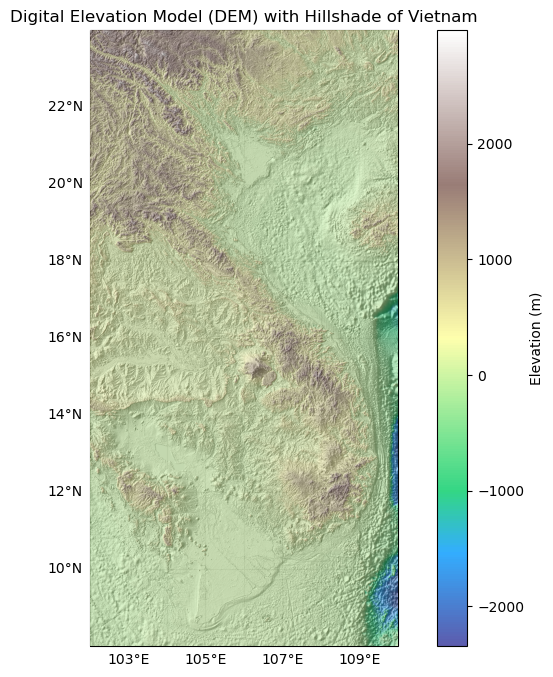

In [16]:
#DEM directory
dem_path = '/home/sahar/output_tif/Vietnam_DEM.tif'

#read DEM
with rasterio.open(dem_path) as src:
    # Read the DEM data as a numpy array
    dem_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(dem_array, 330, 30)


#get the extent f the DEM
with rasterio.open(dem_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
#ax.coastlines(zorder= 10)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot DEM
cax = ax.imshow(dem_array, cmap= 'terrain', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)#GMT colormaps instead could be used
plt.colorbar(cax, label='Elevation (m)')
plt.title('Digital Elevation Model (DEM) with Hillshade of Vietnam')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Mean Sea Surface
The mean sea surface is the displacement of the sea surface relative to a mathematical model of the earth and it closely follows the geoid. Amplitudes ranges between +/- 100 meters. https://www.space.dtu.dk/english/research/scientific_data_and_models/global_mean_sea_surface 7/17/2023. The DTU15MSS is the latest release of the global high resolution mean sea surface from DTU Space. Therefore for this research the netcdf dataset of DT15MSS with 1 min resolution is used as the Mean Sea Surface https://ftp.space.dtu.dk/pub/DTU15/1_MIN/ 7/17/2023. 

The netcdf file then converted to geotiff and masked for te study area in QGIS.

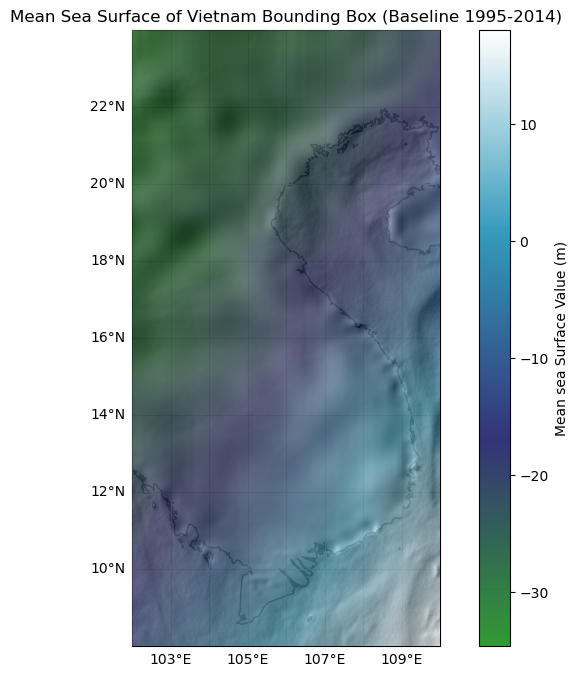

In [17]:
#Mean Sea Surface (MSS) directory
dir_mss = '/home/sahar/output_tif/Vietnam_MSS.tif'

#read mean sea surface in rasterio
with rasterio.open(dir_mss) as src:
    #read the mean sea surface data as a numpy array
    mss_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(mss_array, 330, 30)

#get the extent of the mean sea surface
with rasterio.open(dir_mss) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot mean sea surface
cax = ax.imshow(mss_array, cmap='ocean', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Mean sea Surface Value (m)')
plt.title('Mean Sea Surface of Vietnam Bounding Box (Baseline 1995-2014)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Computation pre-requirements
For computation of the maps, they need to be in a same coordinate reference system, have the same extent (otherwise the map with smallest extent will be considered as the extent reference) and the geographical resolution of the computation result should be defined before hand. Here, to have the most acurate simulation the resolution of the data with highest resolution is referenced which is ETOPO Bedrock and Geoid with 15 arc seconds resolution. 
First the coordinates of all datasets are checked using rasterio package. They all are in **EPSG 4326** which is **WGS84** ellipsoid.

In [18]:
#Bedrock
with rasterio.open('/home/sahar/output_tif/Vietnam_Bedrock_15arcsec.tiff') as src:
    #read the image data
    image = src.read(1)
    #get transform and bounds of the image
    transform = src.transform
    bounds = src.bounds
    #get crs
    crs = src.crs
    print("CRS of DEM:", crs)

#Geoid
with rasterio.open('/home/sahar/output_tif/Vietnam_bbox_Geoid_15s.tif') as src:
    #read the image data
    image = src.read(1)
    #get transform and bounds of the image
    transform = src.transform
    bounds = src.bounds
    #get crs
    crs = src.crs
    print("CRS of Geoid:", crs)
#IPCC SLC
with rasterio.open('/home/sahar/output_tif/grid2/sea_level_change_alt_2100_SLC_median_ssp119.tif') as src:
    #read the image data
    image = src.read(1)
    #get transform and bounds of the image
    transform = src.transform
    bounds = src.bounds
    #get crs
    crs = src.crs
    print("CRS of IPCC SL:", crs)

#DTU MSS
with rasterio.open('/home/sahar/output_tif/Vietnam_MSS.tif') as src:
    #read the image data
    image = src.read(1)
    #get transform and bounds of the image
    transform = src.transform
    bounds = src.bounds
    #get crs
    crs = src.crs
    print("CRS of MSS:", crs)


CRS of DEM: EPSG:4326
CRS of Geoid: EPSG:4326
CRS of IPCC SL: EPSG:4326
CRS of MSS: EPSG:4326


In the next steps that are performed in QGIS, all output rasters are produced with **15 arc seconds** resolution.

# Sea Level for the intended epochs
Since the sea level change projection is relative to the baseline of the 1995 to 2014, in order to have the sea level height for future epochs, the sea level change projection maps are added to the Mean Sea Surface of the baseline. This process has been done using Raster calculator in QGIS, for example for scenario-ssp119 of the year 2020:

Vietnam_MSS2014plusIPCC_2020_ssp119.tif = "Vietnam_bbox_Geoid_15s@1" + "Vietnam_sea_level_change_alt_nearest2020_SLC_median_ssp119@1"

The maps are plotted here using **gdal** package.

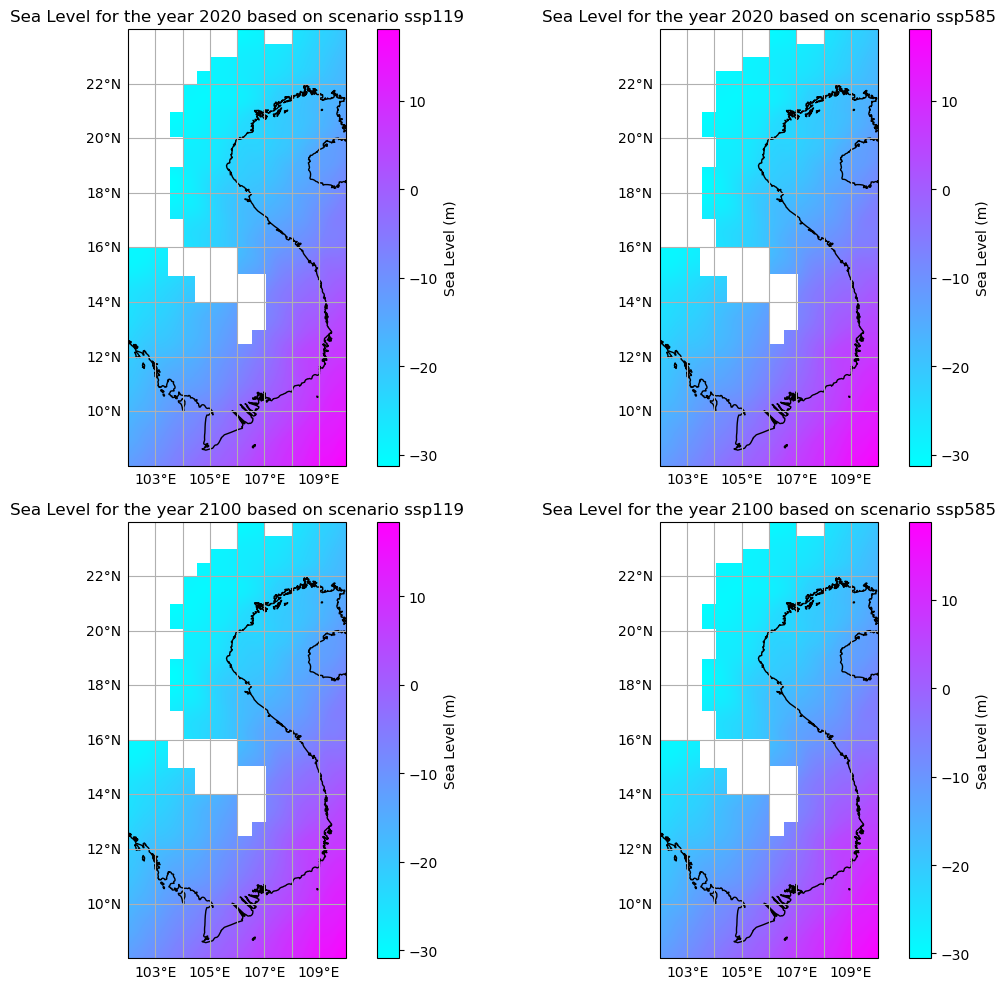

In [19]:
#list of sea level change for all years and scenarios
dir_Sea_Level = [
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2020_ssp119.tif',
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2020_ssp585.tif',
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2100_ssp119.tif',
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2100_ssp585.tif'
]
#list for interation
scenarios = ['ssp119', 'ssp585', 'ssp119', 'ssp585']
years = ['2020', '2020', '2100', '2100']
#plot the sea level maps in a loop
fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

#define intergrated legend
n= 50 #range of colors
cmap = cm.get_cmap('cool', n-1) #create cmap of n-1 ranges
cranges = np.linspace(-31.15, 18.4, n) #(put n ranges btw min SL and max SL)
norms = colors.BoundaryNorm(cranges, cmap.N)


for i, SL in enumerate(dir_Sea_Level):
    dataset = gdal.Open(SL)
    band = dataset.GetRasterBand(1)
    SL_array = band.ReadAsArray()

    transform = dataset.GetGeoTransform()
    x_res = transform[1]
    y_res = transform[5]
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    xmin, ymin, xmax, ymax = bbox
    x_vals = np.arange(xmin, xmax, x_res)
    y_vals = np.arange(ymin, ymax, y_res)

    ax = axs[i // 2, i % 2]
    #im = ax.imshow(SL_array, extent=[xmin, xmax, ymin, ymax], cmap= cmap, norm= norms)
    im = ax.imshow(SL_array, extent=[xmin, xmax, ymin, ymax], cmap= 'cool')
    gl = ax.gridlines(draw_labels=True)

    gl.right_labels = False

    gl.top_labels = False
    ax.set_title(f'Sea Level for the year {years[i]} based on scenario {scenarios[i]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Sea Level (m)')

    ax.coastlines()

plt.tight_layout()
plt.show()


# Visualizing Sea Level and DEM with the same legend
Here in order to be able to compare Digital Elevation Model and future Sea Level height and to have an initial idea of the flooded area, theses maps are plotted with the same range and color. colormap and normalization method of **mathplotlib** is used to integrate the legend.

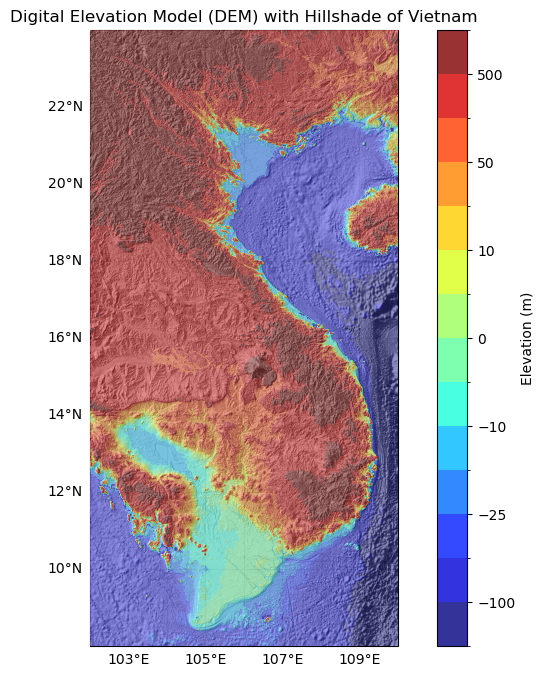

In [23]:
#DEM directory
dem_path = '/home/sahar/output_tif/Vietnam_DEM.tif'

#read DEM
with rasterio.open(dem_path) as src:
    # Read the DEM data as a numpy array
    dem_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(dem_array, 330, 30)


#get the extent f the DEM
with rasterio.open(dem_path) as src:
    xmin, ymin, xmax, ymax = src.bounds
#plot DEM
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
#ax.coastlines(zorder= 10)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)

#define intergrated legend

cmap = cm.get_cmap('jet', 14) #create cmap of n-1 ranges
cranges = [-2000, -30, -20, -10, -5, 0, 5, 10, 18, 50, 100, 500, 2000]
norms = colors.BoundaryNorm(cranges, cmap.N)
#cax = ax.imshow(dem_array, cmap= 'terrain', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)#GMT colormaps instead could be used
cax = ax.imshow(dem_array, cmap= cmap, norm= norms, extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)#GMT colormaps instead could be used

plt.colorbar(cax, label='Elevation (m)')
plt.title('Digital Elevation Model (DEM) with Hillshade of Vietnam')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

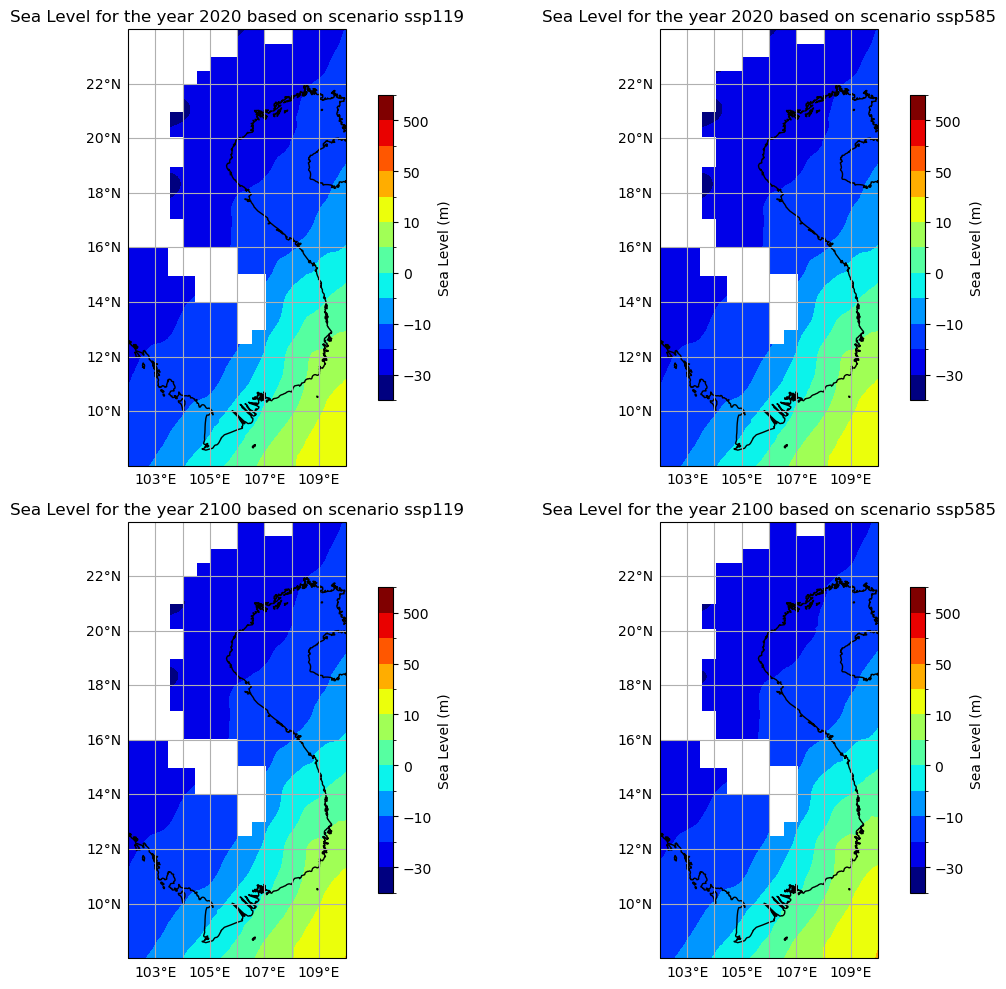

In [27]:
#list of sea level change for all years and scenarios
dir_Sea_Level = [
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2020_ssp119.tif',
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2020_ssp585.tif',
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2100_ssp119.tif',
    '/home/sahar/output_tif/grid2/Vietnam_MSS2014plusIPCC_2100_ssp585.tif'
]
#list for interation
scenarios = ['ssp119', 'ssp585', 'ssp119', 'ssp585']
years = ['2020', '2020', '2100', '2100']
#plot the sea level maps in a loop
fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

#define intergrated legend
cmap = cm.get_cmap('jet', 12) #create cmap of n-1 ranges
cranges = [-2000, -30, -20, -10, -5, 0, 5, 10, 18, 50, 100, 500, 2000]
norms = colors.BoundaryNorm(cranges, cmap.N)


for i, SL in enumerate(dir_Sea_Level):
    dataset = gdal.Open(SL)
    band = dataset.GetRasterBand(1)
    SL_array = band.ReadAsArray()

    transform = dataset.GetGeoTransform()
    x_res = transform[1]
    y_res = transform[5]
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize
    xmin, ymin, xmax, ymax = bbox
    x_vals = np.arange(xmin, xmax, x_res)
    y_vals = np.arange(ymin, ymax, y_res)

    ax = axs[i // 2, i % 2]
    im = ax.imshow(SL_array, extent=[xmin, xmax, ymin, ymax], cmap= cmap, norm= norms)
    #im = ax.imshow(SL_array, extent=[xmin, xmax, ymin, ymax], cmap= 'cool')
    gl = ax.gridlines(draw_labels=True)

    gl.right_labels = False

    gl.top_labels = False
    ax.set_title(f'Sea Level for the year {years[i]} based on scenario {scenarios[i]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label('Sea Level (m)')

    ax.coastlines()

plt.tight_layout()
plt.show()


# Creating Flood Maps
Having the sea level height for the perspective years, and the topography of the study area, we are able to identify the flooded area. This process has been done in QGIS with raster calculator, in such a way that all pixels whose elevation is lower than the sea level height are flooded. For example for scenario-ssp119 of the year 2020 the flooded area will be where:

"Vietnam_DEM.tif" <= "Vietnam_MSS2014plusIPCC_2020_ssp119.tif"

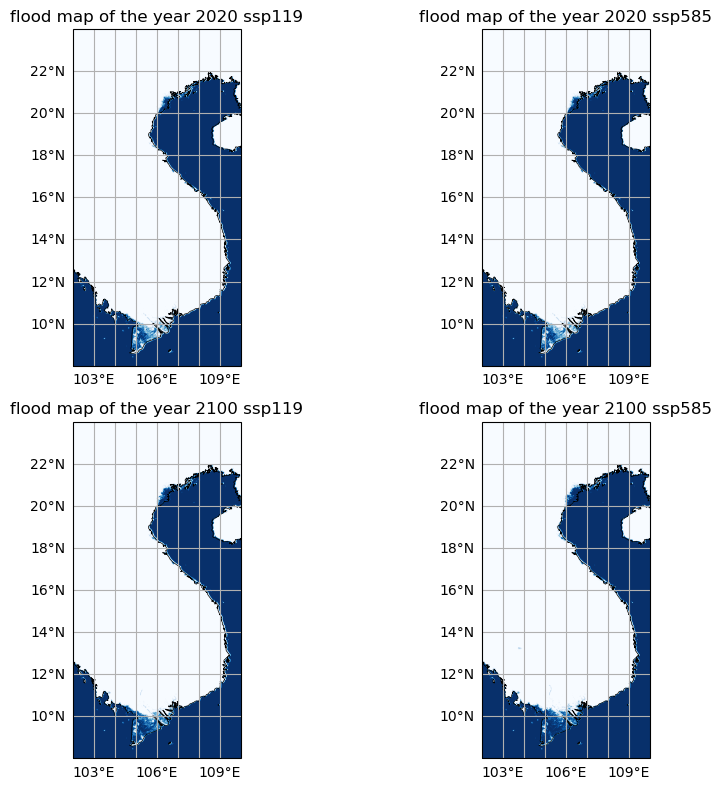

In [22]:
#importing and plotting the flood map created in QGIS
#list of the flood maps
dir_floods = {
    'flood map of the year 2020 ssp119': '/home/sahar/output_tif/grid2/Vietnam_flood_2020_ssp119.tif',
    'flood map of the year 2020 ssp585': '/home/sahar/output_tif/grid2/Vietnam_flood_2020_ssp585.tif',
    'flood map of the year 2100 ssp119': '/home/sahar/output_tif/grid2/Vietnam_flood_2100_ssp119.tif',
    'flood map of the year 2100 ssp585': '/home/sahar/output_tif/grid2/Vietnam_flood_2100_ssp585.tif',
}

crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': crs})

for ax, (title, file_path) in zip(axs.flat, dir_floods.items()):
    with rasterio.open(file_path) as src:
        flood_map = src.read(1)
        transform = src.transform
        bounds = src.bounds

    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    im = ax.imshow(flood_map, extent=extent, cmap='Blues', vmin=0, vmax=1, origin='upper', transform=crs)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)

    gl = ax.gridlines(draw_labels=True)

    gl.right_labels = False

    gl.top_labels = False
    ax.coastlines(resolution='10m', color='black', linewidth=0.5)

plt.tight_layout()
plt.show()
